In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

For our data collection, we recorded the traffic from four different WhatsApp Web groups, each exhibiting distinct characteristics: 

Group A: Only picture messages were sent within this group.<br>
Group B: Only long text messages were exchanged in this group.<br>
Group C: This group contained only video file transfers between members.<br>
Group D: Audio files were the sole media type sent in this group.<br>
This diversity in group traffic composition allowed us to analyze whether unique fingerprints emerged in the timing and size patterns for different content types.<br>

Additionally, we captured a second dataset from Group A. In this new capture, while still only sending pictures, we added background "noise" by streaming music on Spotify concurrently.<br> By comparing this noisy capture to the initial clean Group A traffic, we could examine the impact of mixed media streams on identifying underlying messaging patterns.<br>

We also captured a third dataset from different groups mixed together.In this new capture we sent two pictures, one video and one long message.<br> We tried to understand from this how different times look next to each other.

### Pictures Group

In [2]:
pictures_data = pd.read_csv("../resources/pictures_data.csv")
pictures_data.head()
pictures_data = pictures_data.loc[pictures_data['Length'] > 500]

In [3]:
#pictures_data_filtered = pictures_data[pictures_data['Protocol'].str.contains('TLS')] 

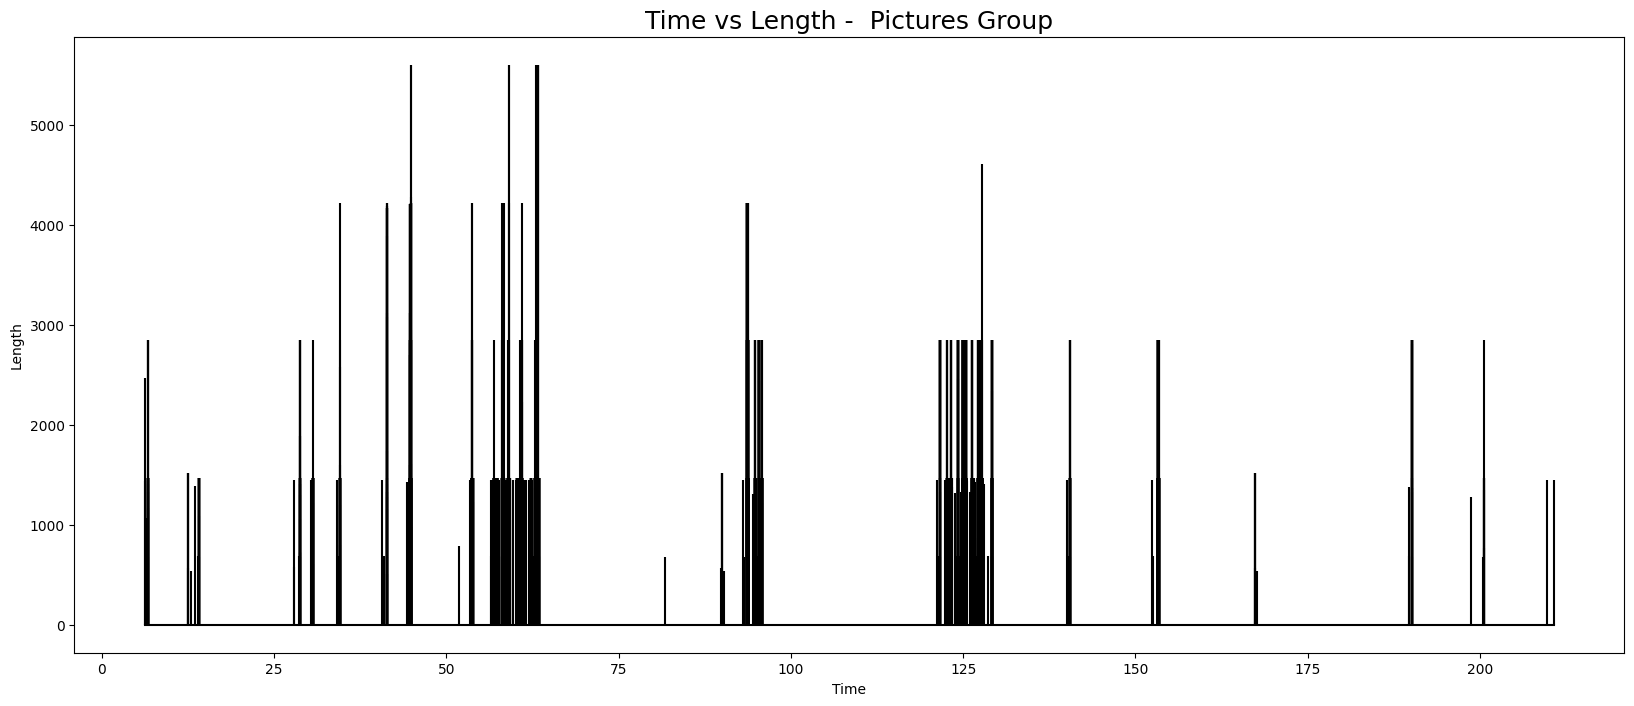

In [59]:
time = pictures_data['Time']
len = pictures_data['Length'] 
plt.figure(figsize=(20,8)) 
plt.stem(time, len,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Time vs Length -  Pictures Group',fontsize=18)
plt.show()

In [61]:
picture_time_diff = pictures_data['Time'].diff().shift(-1)
picture_time_diff

8       0.023208
9       0.124610
15      0.054075
21      0.105982
29      0.123777
          ...   
4403    0.032604
4406    0.000783
4408    9.086711
4419    1.021963
4425         NaN
Name: Time, Length: 2139, dtype: float64

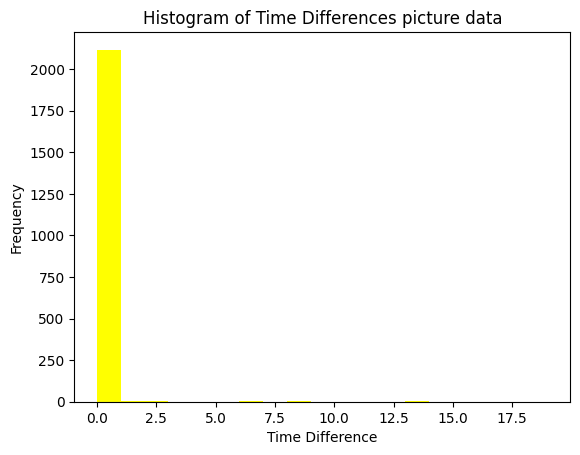

In [64]:
bins = range(0,20) 

# Histogram 
plt.hist(picture_time_diff, bins=bins,color= 'yellow')

# Labels  
plt.xlabel('Time Difference')
plt.ylabel('Frequency')

# Title
plt.title('Histogram of Time Differences picture data',fontsize=12)
# Show plot
plt.show()

### Video Group 

In [5]:
video_data = pd.read_csv("../resources/filter by port = 443/video_data.csv", encoding='latin-1')
video_data

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.1.12,157.240.214.60,TLSv1.2,1267,Application Data
1,2,0.243511,157.240.214.60,192.168.1.12,TCP,68,443 > 37132 [ACK] Seq=1 Ack=1200 Win=750 Len...
2,3,0.448372,157.240.214.60,192.168.1.12,TLSv1.2,155,Application Data
3,4,0.448406,192.168.1.12,157.240.214.60,TCP,68,37132 > 443 [ACK] Seq=1200 Ack=88 Win=501 Le...
4,5,0.544376,2a00:a041:3c5d:4d00:f27a:171e:3a3f:4952,2606:4700::6812:2a2,TCP,88,49290 > 443 [ACK] Seq=1 Ack=1 Win=501 Len=0 ...
...,...,...,...,...,...,...,...
1153,1154,787.012452,192.168.1.12,51.140.219.248,TCP,56,[TCP Keep-Alive] 59938 > 443 [ACK] Seq=1525 ...
1154,1155,787.035557,20.42.73.27,192.168.1.12,TCP,62,"443 > 34016 [RST, ACK] Seq=8321 Ack=48864 Wi..."
1155,1156,787.134124,51.140.219.248,192.168.1.12,TCP,62,[TCP Keep-Alive ACK] 443 > 59938 [ACK] Seq=1...
1156,1157,793.120382,192.168.1.12,20.93.28.56,TCP,68,[TCP Dup ACK 57#17] 39298 > 443 [ACK] Seq=1 ...


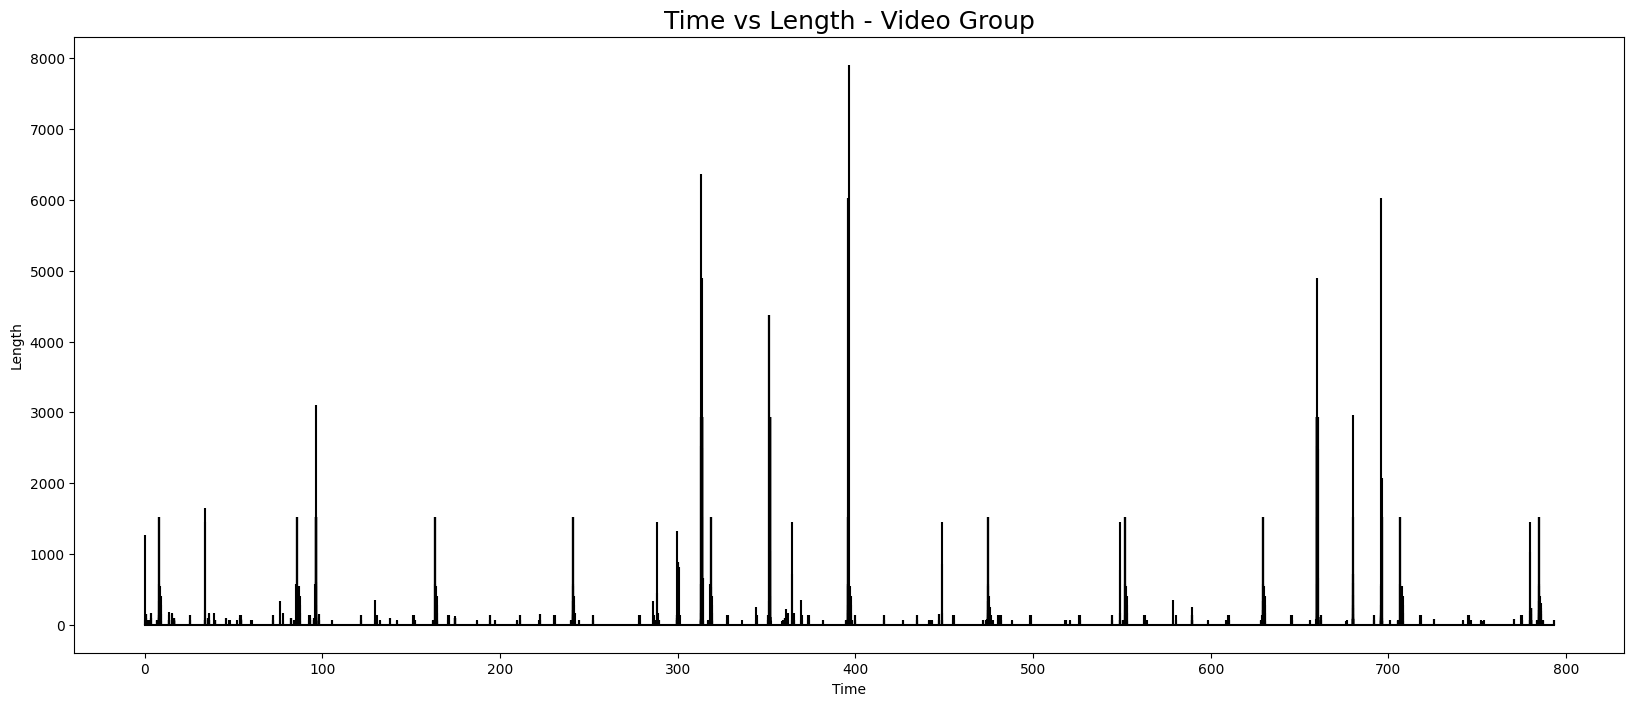

In [67]:
# video_data_filtered = video_data[video_data['Protocol'].str.contains('TLS')] 

time = video_data['Time']
len = video_data['Length']
plt.figure(figsize=(20,8)) 
plt.stem(time, len,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Time vs Length - Video Group',fontsize=18)
plt.show()

In [7]:
filter_src_dst = video_data.loc[(video_data['Source']=='157.240.214.60') | (video_data['Destination']=='157.240.214.60')]
filter_src_dst = filter_src_dst.loc[filter_src_dst['Length'] > 100]
filter_src_dst

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.1.12,157.240.214.60,TLSv1.2,1267,Application Data
2,3,0.448372,157.240.214.60,192.168.1.12,TLSv1.2,155,Application Data
6,7,0.755726,157.240.214.60,192.168.1.12,TLSv1.2,148,Application Data
8,9,0.760677,192.168.1.12,157.240.214.60,TLSv1.2,146,Application Data
54,55,13.345355,192.168.1.12,157.240.214.60,TLSv1.2,134,Application Data
...,...,...,...,...,...,...,...
1114,1115,780.257062,192.168.1.12,157.240.214.60,TLSv1.2,238,"Application Data, Application Data"
1147,1148,785.966305,157.240.214.60,192.168.1.12,TLSv1.2,304,Application Data
1148,1149,785.969187,192.168.1.12,157.240.214.60,TLSv1.2,187,Application Data
1150,1151,786.050237,157.240.214.60,192.168.1.12,TLSv1.2,233,Application Data


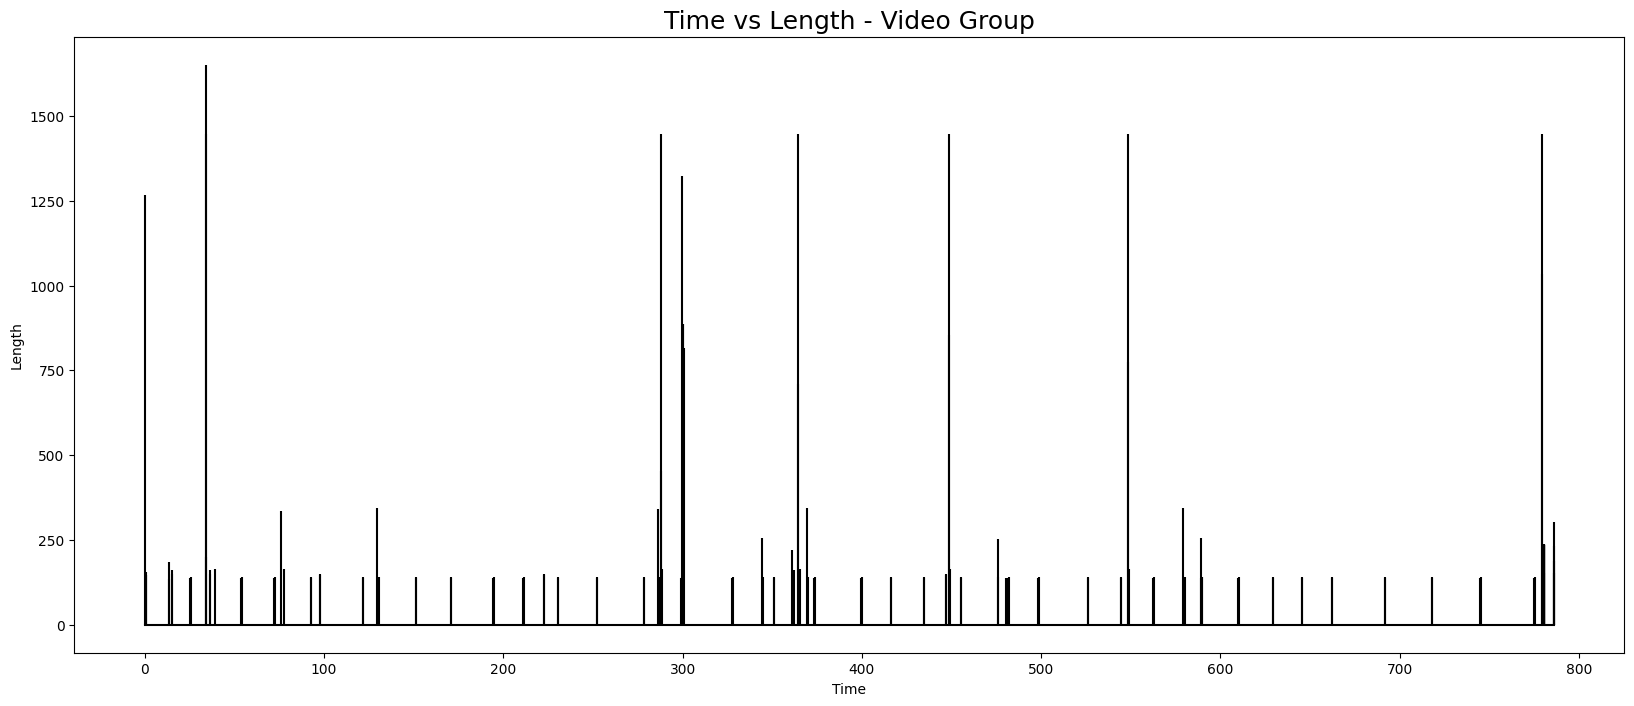

In [69]:
time = filter_src_dst['Time']
len = filter_src_dst['Length']
plt.figure(figsize=(20,8)) 
plt.stem(time, len,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Time vs Length - Video Group' ,fontsize=18)
plt.show()

In [9]:
video_time_diff = filter_src_dst['Time'].diff().shift(-1)
video_time_diff

0        0.448372
2        0.307353
6        0.004952
8       12.584678
54       0.005428
          ...    
1114     5.709243
1147     0.002882
1148     0.081050
1150     0.002829
1151          NaN
Name: Time, Length: 150, dtype: float64

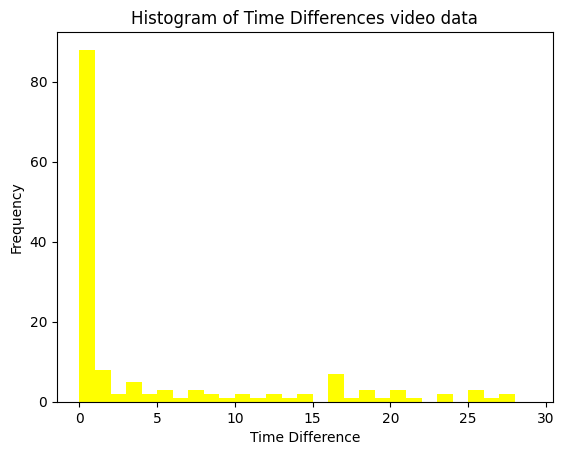

In [10]:
bins = range(0,30) 

# Histogram 
plt.hist(video_time_diff, bins=bins,color= 'yellow')

# Labels  
plt.xlabel('Time Difference')
plt.ylabel('Frequency')

# Title
plt.title('Histogram of Time Differences video data')
# Show plot
plt.show()

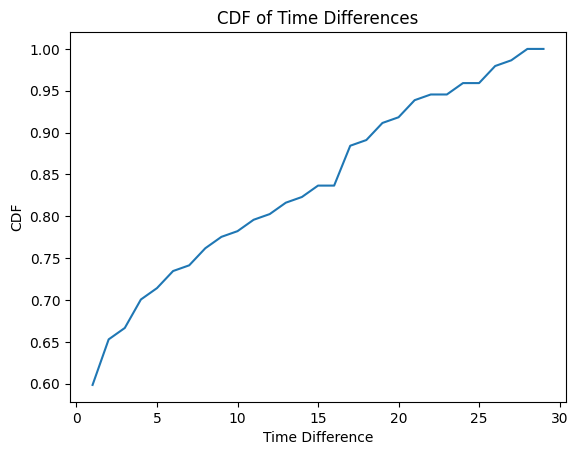

In [11]:

bins = range(0,30) 

# Get histogram 
counts, bin_edges = np.histogram(video_time_diff, bins=bins)

# CDF 
cdf = np.cumsum(counts) 

# Normalize CDF
cdf = cdf / cdf[-1]

# Plot CDF 
plt.plot(bin_edges[1:], cdf)

# Labels
plt.xlabel('Time Difference')
plt.ylabel('CDF')

# Title
plt.title('CDF of Time Differences')

plt.show()

### Voice Group 

In [12]:
voice_data = pd.read_csv("../resources/voice_data.csv")
voice_data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,8,3.376061,192.168.1.12,157.240.221.60,TLSv1.2,135,Application Data
1,9,3.453656,157.240.221.60,192.168.1.12,TCP,66,443 > 40778 [ACK] Seq=1 Ack=70 Win=393 Len=0...
2,10,3.581083,157.240.221.60,192.168.1.12,TLSv1.2,137,Application Data
3,11,3.581118,192.168.1.12,157.240.221.60,TCP,66,40778 > 443 [ACK] Seq=70 Ack=72 Win=501 Len=...
4,12,3.785814,140.82.113.26,192.168.1.12,TLSv1.2,92,Application Data


In [17]:
# voice_data_filtered = voice_data[voice_data['Protocol'].str.contains('TLS')] 

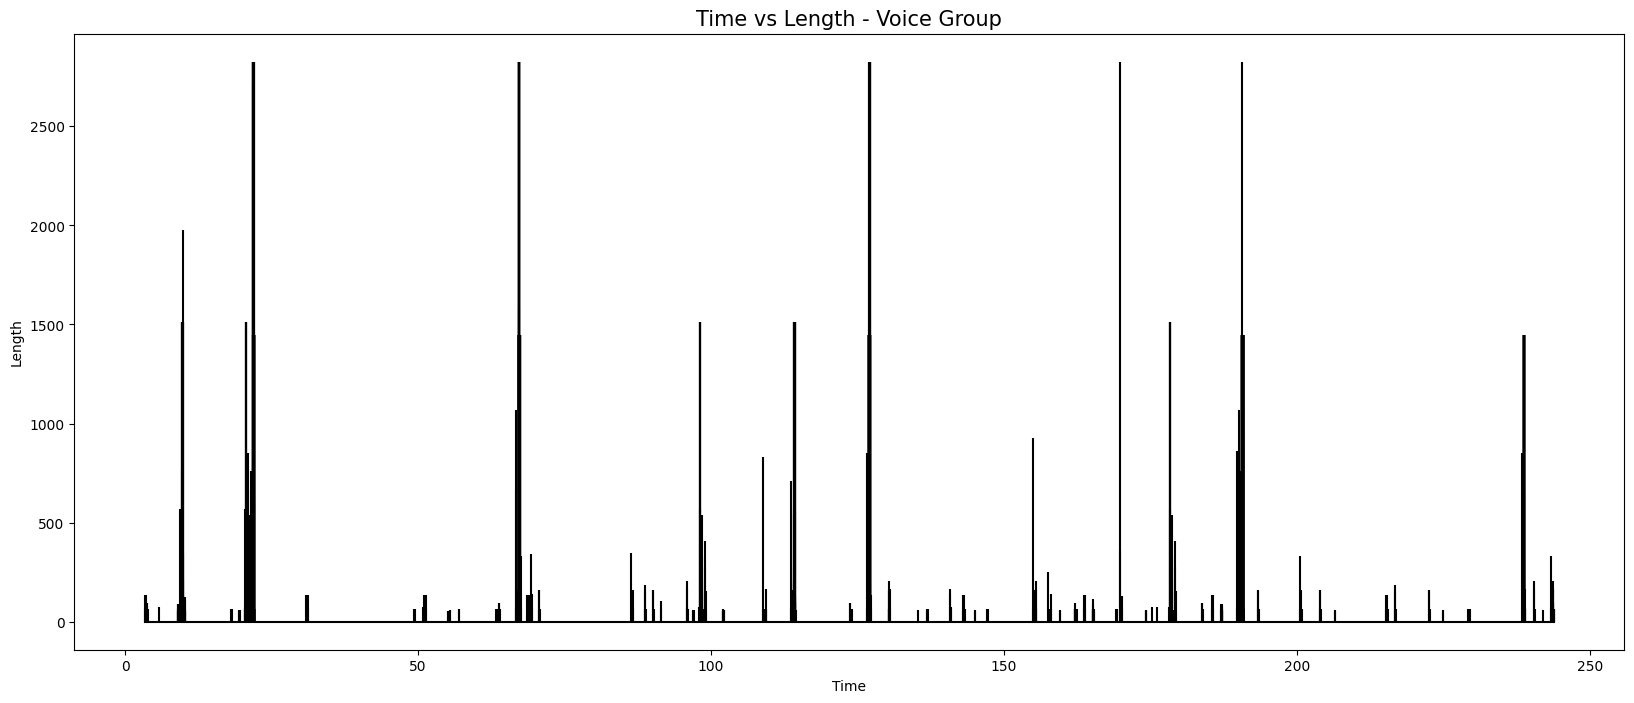

In [73]:
voice_time = voice_data['Time']
voice_len = voice_data['Length']
plt.figure(figsize=(20,8)) 
plt.stem(voice_time, voice_len,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Time vs Length - Voice Group' , fontsize = 15)
plt.show()

In [20]:
voice_time_diff = voice_data['Time'].diff().shift(-1)
voice_time_diff

0      0.077596
1      0.127427
2      0.000034
3      0.204696
4      0.000519
         ...   
929    0.004662
930    0.087840
931    0.000442
932    0.035503
933         NaN
Name: Time, Length: 934, dtype: float64

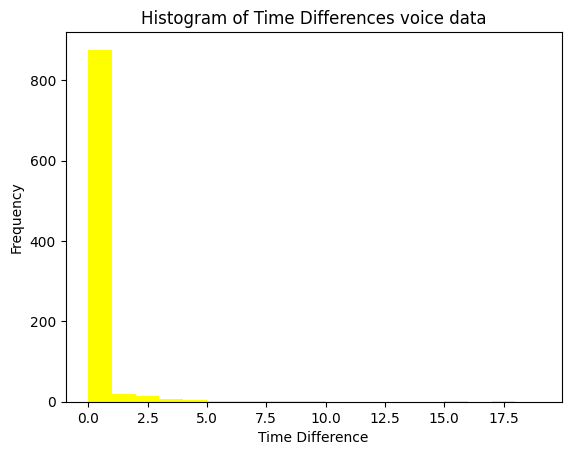

In [21]:
bins = range(0, 20) 

# Histogram 
plt.hist(voice_time_diff, bins=bins,color= 'yellow')

# Labels  
plt.xlabel('Time Difference')
plt.ylabel('Frequency')

# Title
plt.title('Histogram of Time Differences voice data')
# Show plot
plt.show()

### Text Group

In [13]:
text_data = pd.read_csv("../resources/text_data.csv", encoding='latin-1')
text_data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,4,4.400858,157.240.221.60,192.168.1.12,TLSv1.2,433,Application Data
1,5,4.444965,192.168.1.12,157.240.221.60,TCP,66,45474 > 443 [ACK] Seq=1 Ack=368 Win=1015 Len...
2,6,5.030028,192.168.1.12,157.240.221.60,TLSv1.2,165,Application Data
3,7,5.109090,157.240.221.60,192.168.1.12,TCP,66,443 > 45474 [ACK] Seq=368 Ack=100 Win=376 Le...
4,8,6.039570,157.240.221.60,192.168.1.12,TCP,1446,443 > 45474 [ACK] Seq=368 Ack=100 Win=376 Le...


In [94]:
# text_data_filtered = text_data[text_data['Protocol'].str.contains('TLS')] 

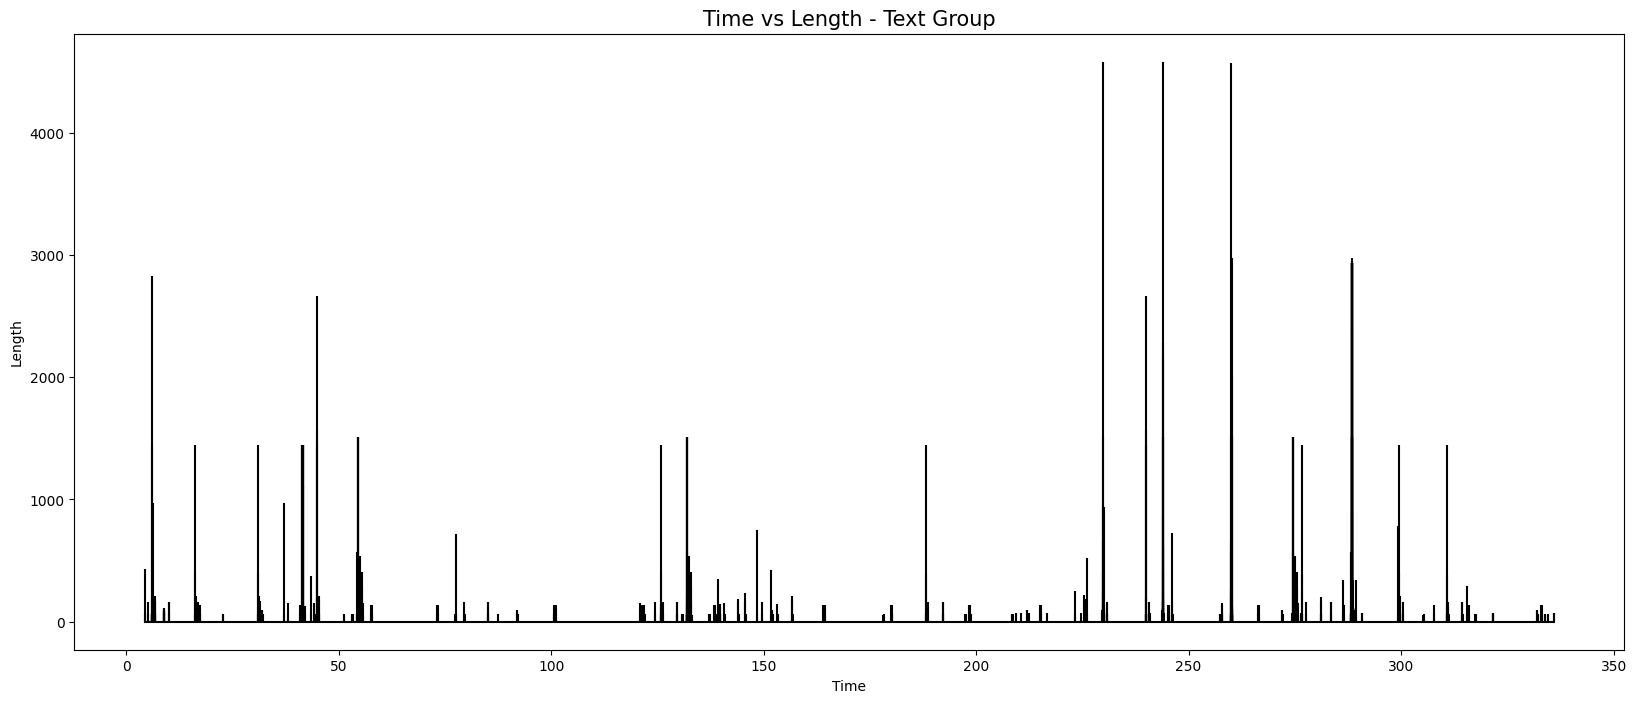

In [72]:
time = text_data['Time']
len = text_data['Length']
plt.figure(figsize=(20,8)) 
plt.stem(time, len,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Time vs Length - Text Group', fontsize= 15)
plt.show()

In [75]:
#filtered length lower than 200 because it is likely to be noise
text_noise_filter = text_data.loc[text_data['Length'] > 200]
text_noise_filter

,No.,Time,Source,Destination,Protocol,Length,Info
0,4,4.400858,157.240.221.60,192.168.1.12,TLSv1.2,433,Application Data
4,8,6.039570,157.240.221.60,192.168.1.12,TCP,1446,443 > 45474 [ACK] Seq=368 Ack=100 Win=376 Le...
7,11,6.040854,157.240.221.60,192.168.1.12,TLSv1.2,2826,Application Data
16,20,6.405551,157.240.221.60,192.168.1.12,TLSv1.2,972,Application Data
19,23,6.806044,157.240.221.60,192.168.1.12,TLSv1.2,207,Application Data
...,...,...,...,...,...,...,...
566,841,299.419316,157.240.221.60,192.168.1.12,TLSv1.2,402,"Application Data, Application Data"
569,844,299.644256,157.240.221.60,192.168.1.12,TLSv1.2,207,Application Data
580,896,310.694810,157.240.221.60,192.168.1.12,TCP,1446,443 > 45474 [ACK] Seq=36087 Ack=17027 Win=48...
582,900,310.695032,157.240.221.60,192.168.1.12,TLSv1.2,384,"Application Data, Application Data"


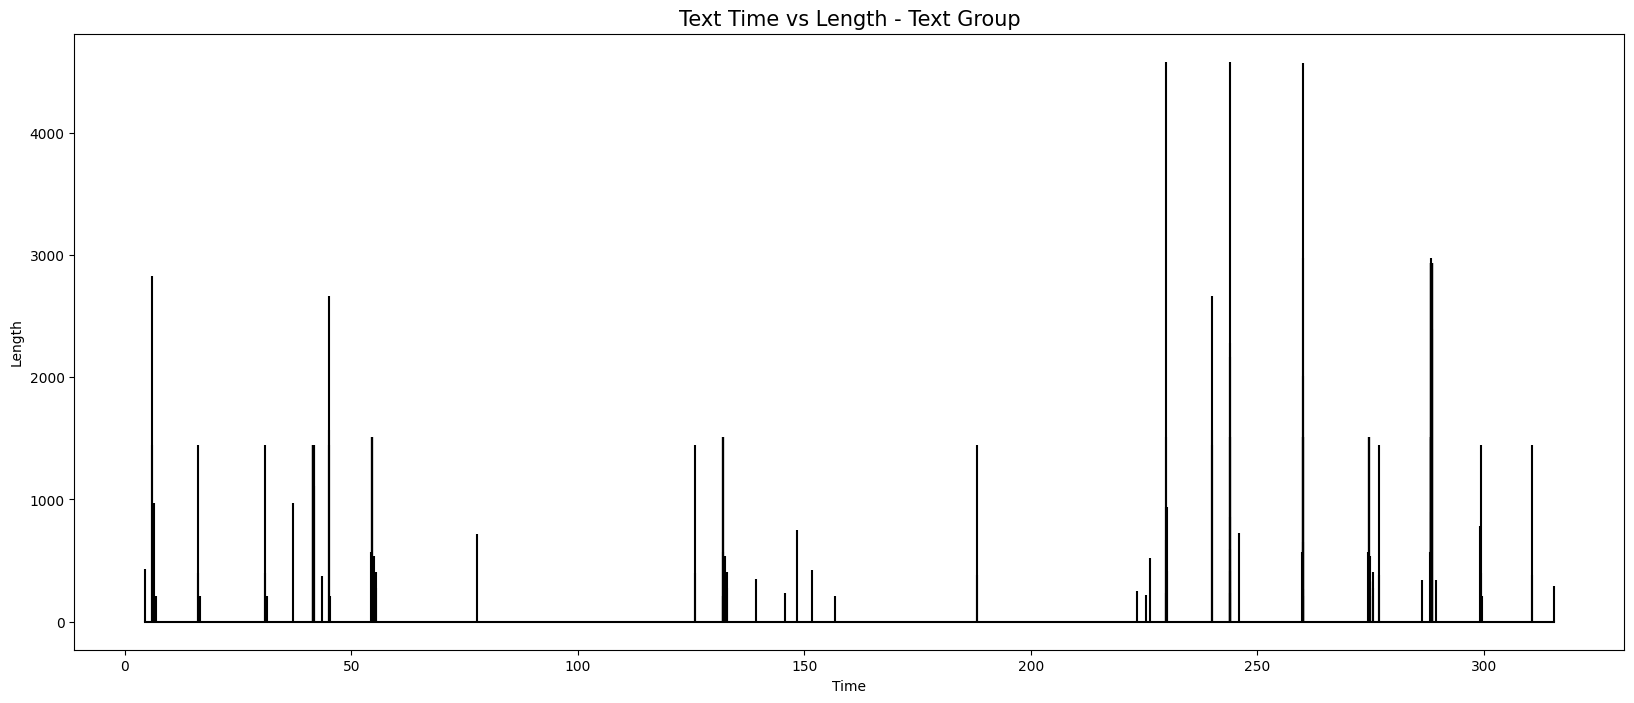

In [76]:
new_time = text_noise_filter['Time']
new_length = text_noise_filter['Length']
plt.figure(figsize=(20,8)) 
plt.stem(new_time, new_length,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Text Time vs Length - Text Group', fontsize= 15)
plt.show()

In [27]:
text_time_diff = text_noise_filter['Time'].diff().shift(-1)
text_time_diff

0       1.638712
4       0.001284
7       0.364697
16      0.400493
19      9.370800
         ...    
566     0.224941
569    11.050554
580     0.000222
582     4.800583
594          NaN
Name: Time, Length: 147, dtype: float64

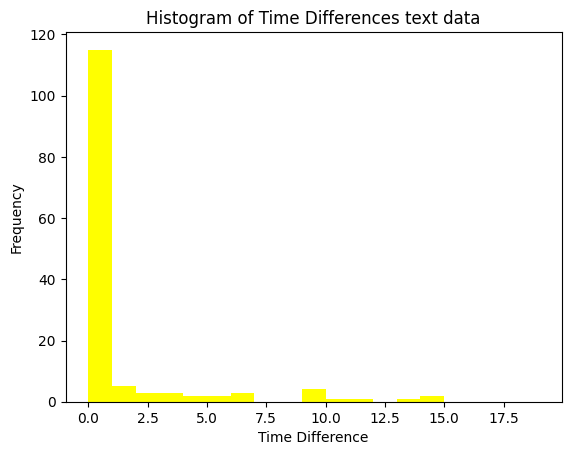

In [28]:
bins = range(0, 20) 

# Histogram 
plt.hist(text_time_diff, bins=bins,color= 'yellow')

# Labels  
plt.xlabel('Time Difference')
plt.ylabel('Frequency')

# Title
plt.title('Histogram of Time Differences text data')
# Show plot
plt.show()

To determine which data can be considered noise and filtered out,<br>
we conducted an experiment where we recorded the transmission of the smallest message size within the group.<br>
This experiment was performed twice, in two separate trials.

The data graphs from the experiment showed that any packets with a size less than 200 bytes were extraneous to the message transmission.<br> Based on these results, we can conclude that packets under 200 bytes can be assumed to be network noise unrelated to the core messages.<br> Therefore, packets smaller than 200 bytes can be safely filtered out without losing meaningful message data.

In [14]:
#test noise size

smallest_text_check1 = pd.read_csv("../resources/smallest_text_data.csv", encoding='latin-1')
smallest_text_check1.head(3)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.1.12,157.240.253.60,TLSv1.2,92,Application Data
1,2,0.000058,192.168.1.12,157.240.253.60,TCP,68,"43198 > 443 [FIN, ACK] Seq=25 Ack=1 Win=501 ..."
2,3,0.004511,192.168.1.12,157.240.253.60,TLSv1.2,92,Application Data


In [15]:

smallest_text_check2 = pd.read_csv("../resources/smallest_text_data2.csv", encoding='latin-1')
smallest_text_check2.head(3)

,No.,Time,Source,Destination,Protocol,Length,Info
0,2,1.638712,157.240.221.60,192.168.1.12,TLSv1.2,145,Application Data
1,3,1.638744,192.168.1.12,157.240.221.60,TCP,68,55824 > 443 [ACK] Seq=1 Ack=78 Win=2849 Len=...
2,7,4.367951,192.168.1.12,157.240.221.60,TLSv1.2,686,Application Data


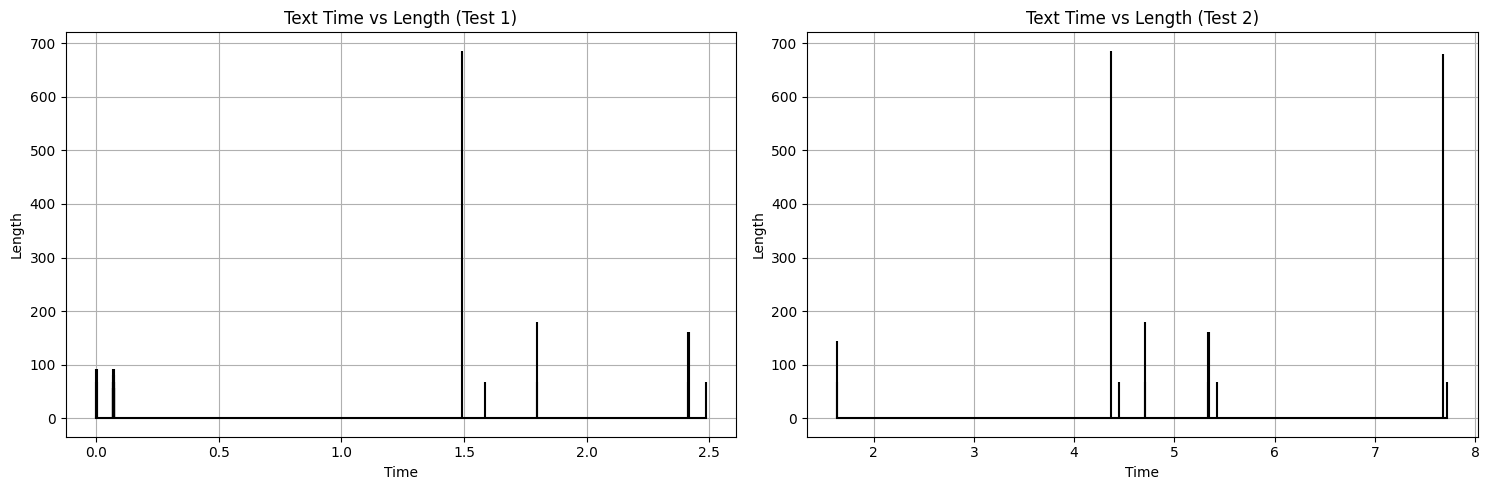

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) 

test1_time = smallest_text_check1['Time']
test1_length = smallest_text_check1['Length']
ax1.stem(test1_time, test1_length, linefmt ='black', markerfmt = '', basefmt='black')
ax1.set_xlabel('Time')
ax1.set_ylabel('Length')
ax1.set_title('Text Time vs Length (Test 1)')
ax1.grid()

test2_time = smallest_text_check2['Time']
test2_length = smallest_text_check2['Length']
ax2.stem(test2_time, test2_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax2.set_xlabel('Time')
ax2.set_ylabel('Length')
ax2.set_title('Text Time vs Length (Test 2)')
ax2.grid()
fig.tight_layout()
plt.show()

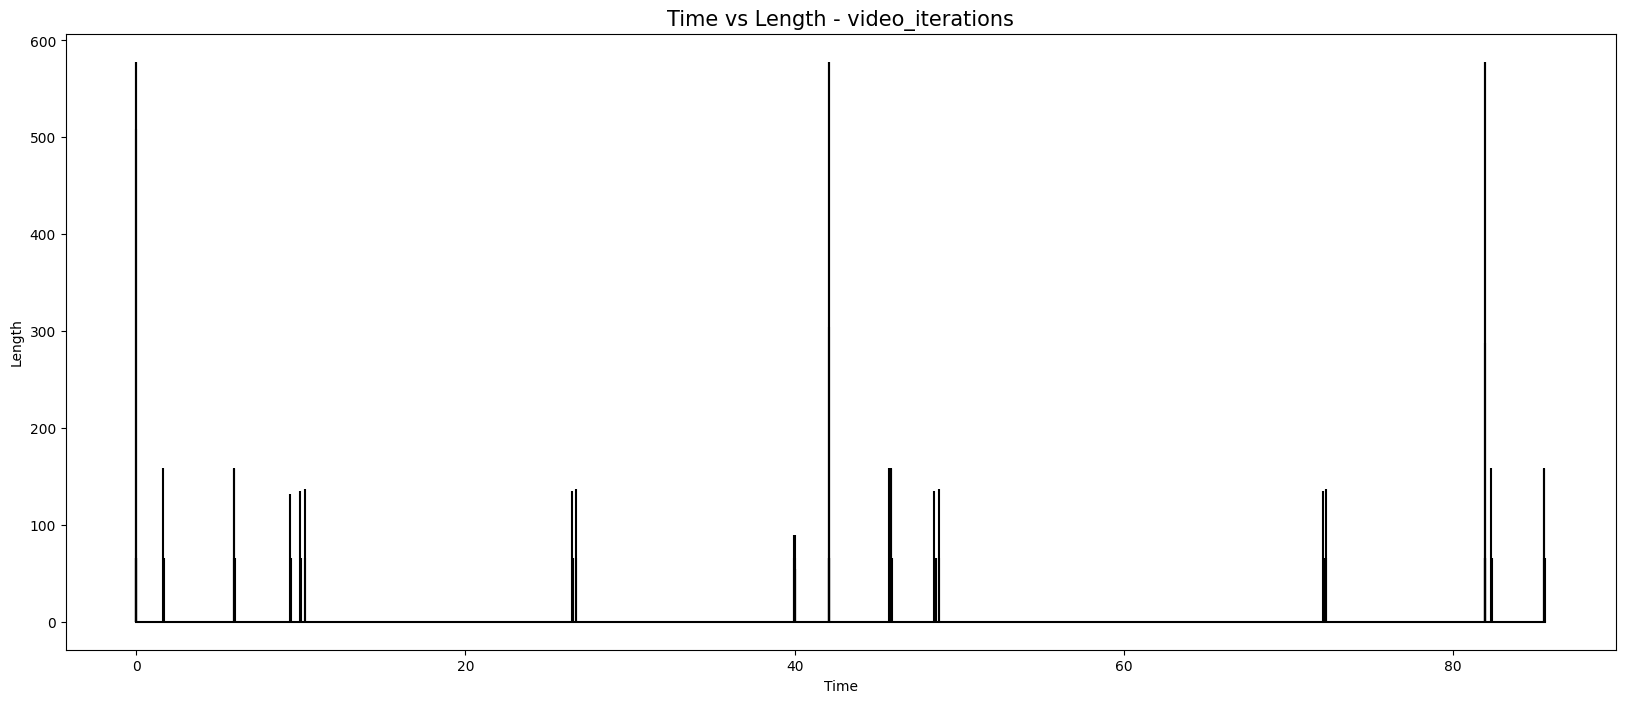

In [77]:
"""
We sent the same video 3 times, with a difference of 40 seconds between each sending, 
in order to observe how the data packets were transmitted. 
We filtered the network traffic (port = 443).
"""
video_iterations = pd.read_csv("../resources/video_iterations.csv", encoding='latin-1')

time = video_iterations['Time']
len = video_iterations['Length']
plt.figure(figsize=(20,8)) 
plt.stem(time, len,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Time vs Length - video_iterations' ,fontsize = 15)
plt.show()

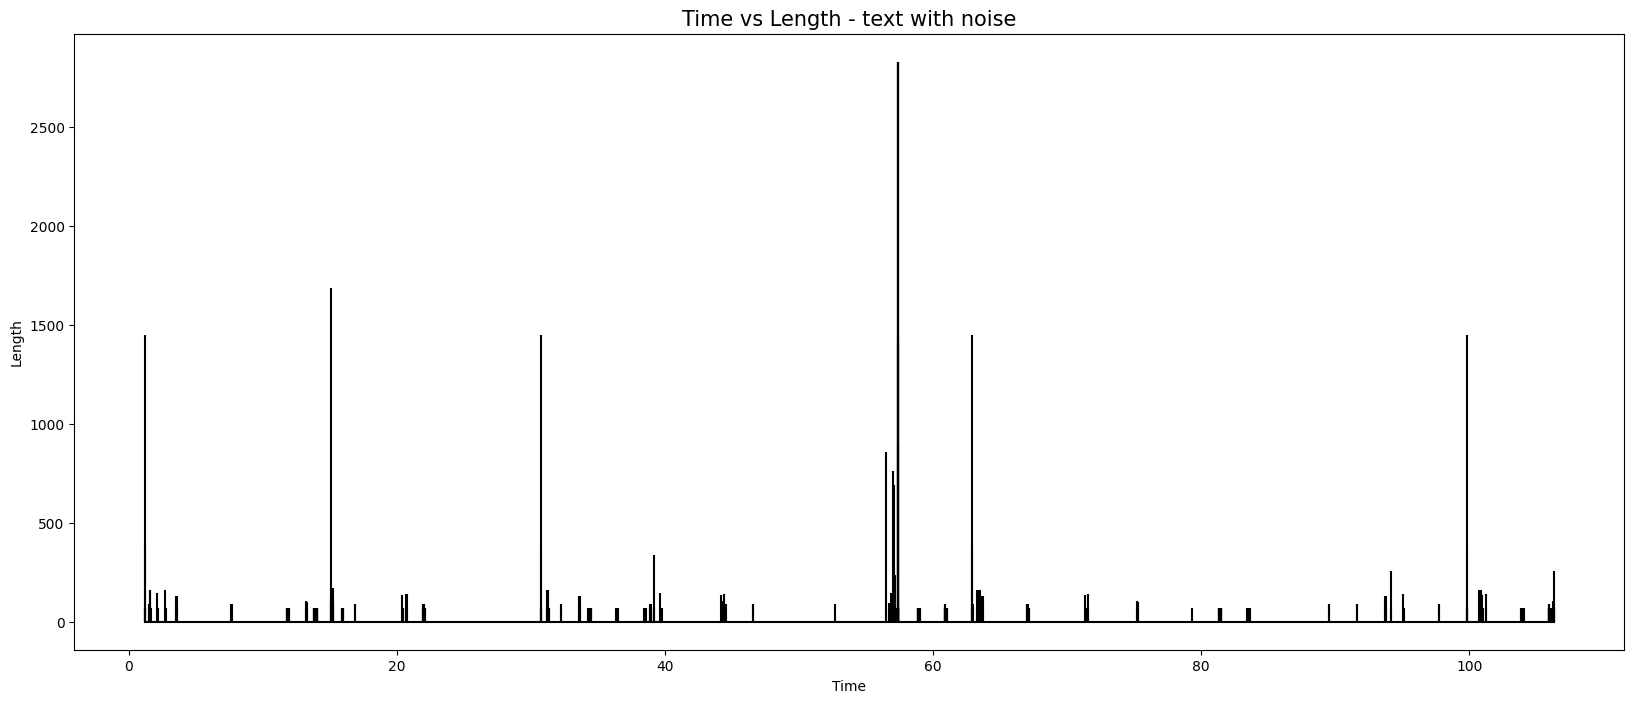

In [78]:
text_with_soptify = pd.read_csv("../resources/text_with_soptify.csv", encoding='latin-1')
text_with_soptify.head(3)

time = text_with_soptify['Time']
len = text_with_soptify['Length']
plt.figure(figsize=(20,8)) 
plt.stem(time, len,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Time vs Length - text with noise', fontsize = 15)
plt.show()

In [18]:
picture_check1 = pd.read_csv("../resources/picture check/picture_check1_data.csv", encoding='latin-1')
picture_check1.head(3)

picture_check2 = pd.read_csv("../resources/picture check/picture_check2_data.csv", encoding='latin-1')
picture_check2.head(3)

picture_check3 = pd.read_csv("../resources/picture check/picture_check3_data.csv", encoding='latin-1')
picture_check3.head(3)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.1.12,157.240.221.60,TLSv1.2,134,Application Data
1,2,0.073619,157.240.221.60,192.168.1.12,TCP,68,443 > 57704 [ACK] Seq=1 Ack=67 Win=346 Len=0...
2,4,0.524901,192.168.1.12,157.240.221.60,TLSv1.2,134,Application Data


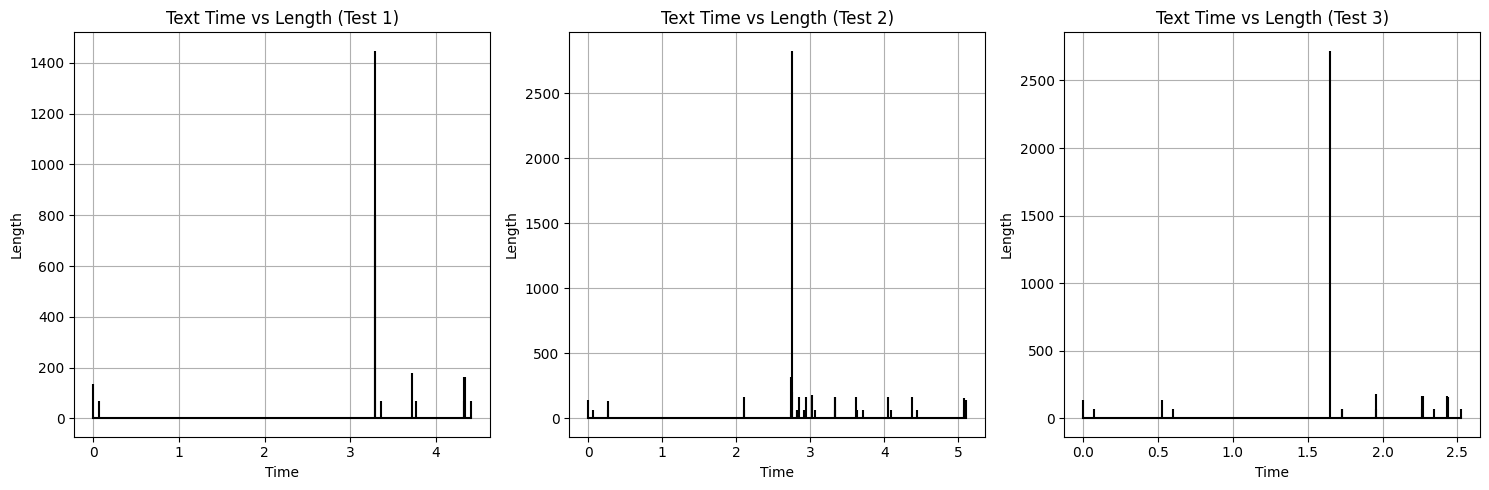

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5)) 

test1_time = picture_check1['Time']
test1_length = picture_check1['Length']
ax1.stem(test1_time, test1_length, linefmt ='black', markerfmt = '', basefmt='black')
ax1.set_xlabel('Time')
ax1.set_ylabel('Length')
ax1.set_title('Text Time vs Length (Test 1)')
ax1.grid()

test2_time = picture_check2['Time']
test2_length = picture_check2['Length']
ax2.stem(test2_time, test2_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax2.set_xlabel('Time')
ax2.set_ylabel('Length')
ax2.set_title('Text Time vs Length (Test 2)')
ax2.grid()

test3_time = picture_check3['Time']
test3_length = picture_check3['Length']
ax3.stem(test3_time, test3_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax3.set_xlabel('Time')
ax3.set_ylabel('Length')
ax3.set_title('Text Time vs Length (Test 3)')
ax3.grid()

fig.tight_layout()
plt.show()

## Mix data

In [20]:
mix_data = pd.read_csv("../resources/mix_data.csv", encoding='latin-1')
mix_data

,No.,Time,Source,Destination,Protocol,Length,Info
0,2,1.639044,157.240.221.60,192.168.1.12,TLSv1.2,148,Application Data
1,3,1.639088,192.168.1.12,157.240.221.60,TCP,68,42240 > 443 [ACK] Seq=1 Ack=81 Win=501 Len=0...
2,4,1.662054,157.240.221.60,192.168.1.12,TCP,148,[TCP Spurious Retransmission] 443 > 42240 [P...
3,5,1.662097,192.168.1.12,157.240.221.60,TCP,80,[TCP Dup ACK 3#1] 42240 > 443 [ACK] Seq=1 Ac...
4,6,2.560693,157.240.221.60,192.168.1.12,TLSv1.2,148,Application Data
...,...,...,...,...,...,...,...
375,443,112.701334,157.240.221.60,192.168.1.12,TCP,68,443 > 42240 [ACK] Seq=8875 Ack=1539 Win=437 ...
376,444,115.317661,192.168.1.12,157.240.221.60,TLSv1.2,137,Application Data
377,445,115.390531,157.240.221.60,192.168.1.12,TCP,68,443 > 42240 [ACK] Seq=8875 Ack=1608 Win=437 ...
378,446,115.613058,157.240.221.60,192.168.1.12,TLSv1.2,139,Application Data


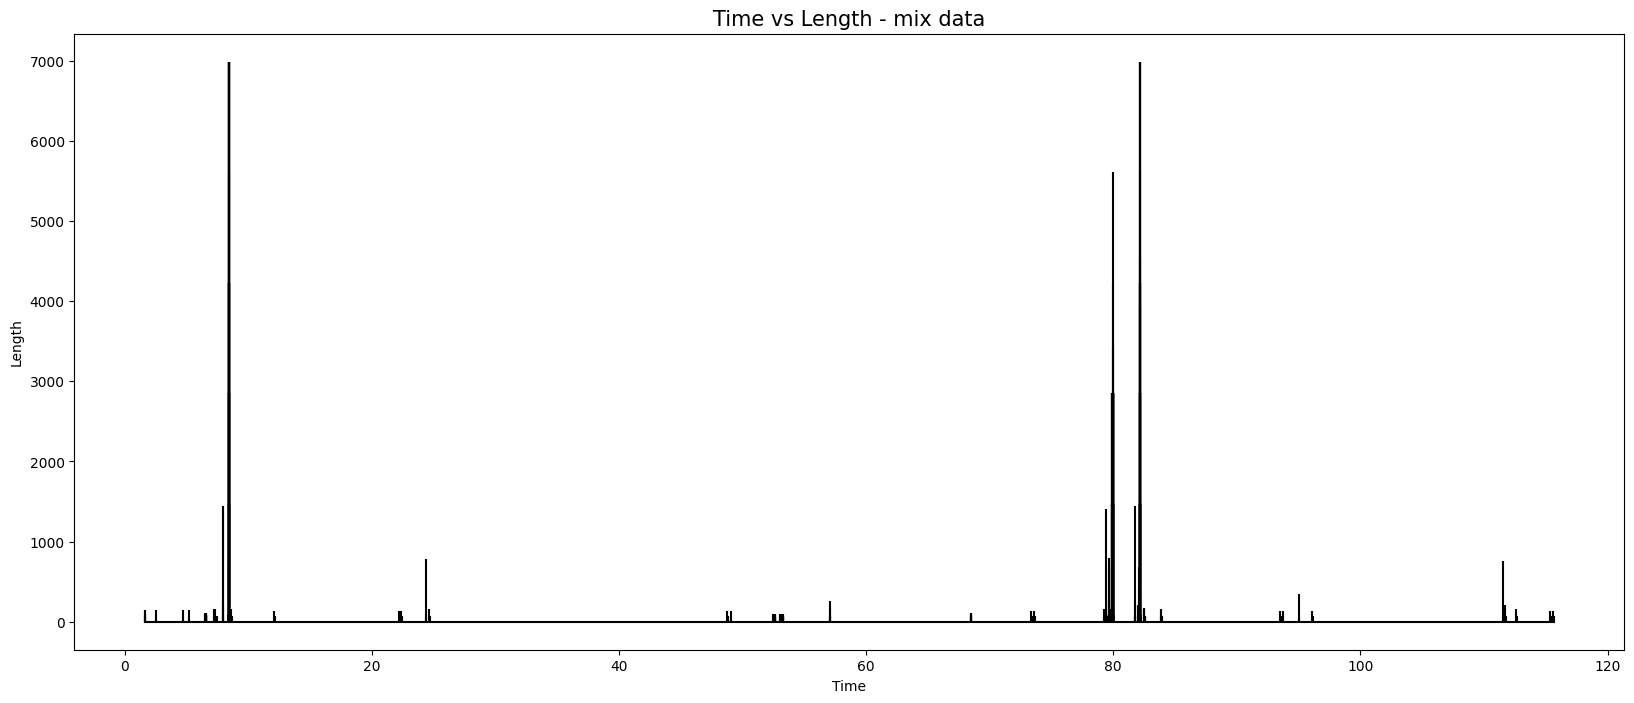

In [79]:
time = mix_data['Time']
len = mix_data['Length']
plt.figure(figsize=(20,8)) 
plt.stem(time, len,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('Length')
plt.title('Time vs Length - mix data' , fontsize = 15)
plt.show()


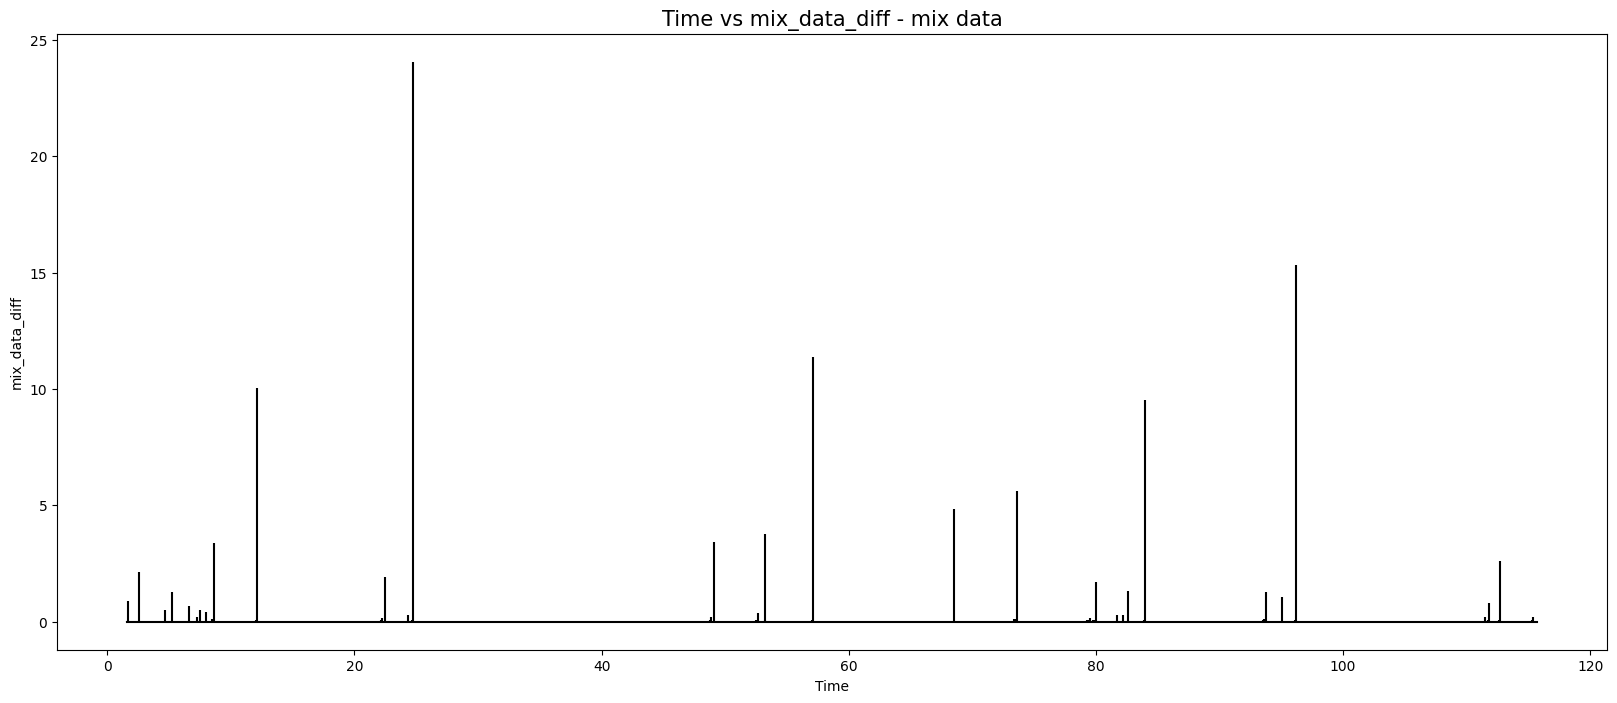

In [84]:

time = mix_data['Time']
mix_data_diff = mix_data['Time'].diff().shift(-1)
plt.figure(figsize=(20,8)) 
plt.stem(time, mix_data_diff,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('mix_data_diff')
plt.title('Time vs mix_data_diff - mix data' , fontsize = 15)
plt.show()


In [22]:
mix_data_diff = mix_data['Time'].diff().shift(-1)
mix_data_diff

0      0.000044
1      0.022967
2      0.000043
3      0.898595
4      0.000040
         ...   
375    2.616327
376    0.072870
377    0.222527
378    0.042149
379         NaN
Name: Time, Length: 380, dtype: float64

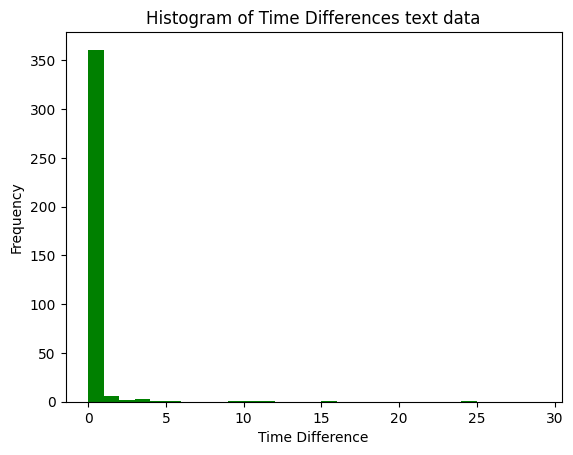

In [23]:
bins = range(0, 30) 

# Histogram 
plt.hist(mix_data_diff, bins=bins,color= 'green')

# Labels  
plt.xlabel('Time Difference')
plt.ylabel('Frequency')

# Title
plt.title('Histogram of Time Differences text data')
# Show plot
plt.show()

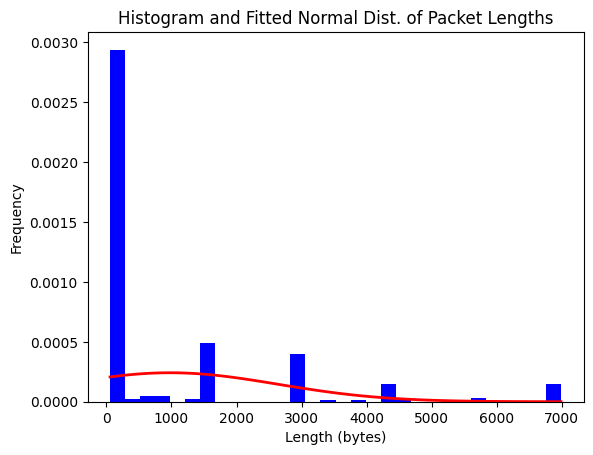

In [24]:
# קריאת הקובץ
df = pd.read_csv('../resources/mix_data.csv')

# היסטוגרמה והתאמת התפלגות
plt.hist(df['Length'], density=True, bins=30, color='b')
mu, std = np.mean(df['Length']), np.std(df['Length'])
x = np.linspace(min(df['Length']), max(df['Length']), 100)
p = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * std**2))
plt.plot(x, p, linewidth=2, color='r')
plt.title('Histogram and Fitted Normal Dist. of Packet Lengths')
plt.xlabel('Length (bytes)')
plt.ylabel('Frequency')
plt.show()

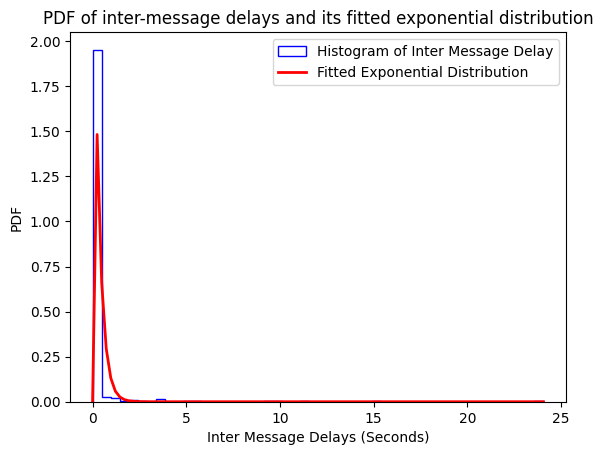

In [82]:


# Extract inter-message delays
imds = df['Time'].diff()[1:].values

# Plot histogram
plt.hist(imds, bins=50, density=True,histtype='step', color='blue')

# Fit exponential distribution
from scipy.stats import expon
param = expon.fit(imds)
x = np.linspace(0, imds.max(), 100)
pdf = expon.pdf(x, *param) 

# Plot fitted exponential pdf
plt.plot(x, pdf, 'r-', lw=2)  

# Labels
plt.title('PDF of inter-message delays and its fitted exponential distribution')
plt.xlabel('Inter Message Delays (Seconds)')  
plt.ylabel('PDF')
plt.legend(['Histogram of Inter Message Delay','Fitted Exponential Distribution']) 

plt.show()
